In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiStepLR

In [ ]:
import torchvision
import torchvision.transforms as pth_transforms
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from PIL import Image
from tqdm.auto import tqdm
import os
from collections import OrderedDict

In [ ]:
!wget --quiet --show-progress https://www.dropbox.com/s/5pylcjrrrtybbmo/camvid.tar?dl=0 -O camvid.tar
!tar -xf camvid.tar

camvid.tar          100%[===================>] 179.24M  22.8MB/s    in 8.0s    


In [ ]:
def get_files(folder, name_filter=None, extension_filter=None):
    if not os.path.isdir(folder):
        raise RuntimeError("\"{0}\" is not a folder.".format(folder))

    if name_filter is None:
        name_cond = lambda filename: True
    else:
        name_cond = lambda filename: name_filter in filename

    if extension_filter is None:
        ext_cond = lambda filename: True
    else:
        ext_cond = lambda filename: filename.endswith(extension_filter)

    filtered_files = []

    for path, _, files in os.walk(folder):
        files.sort()
        for file in files:
            if name_cond(file) and ext_cond(file):
                full_path = os.path.join(path, file)
                filtered_files.append(full_path)

    return filtered_files


def pil_loader(data_path, label_path):
    data = Image.open(data_path)
    label = Image.open(label_path)
    return data, label


class CamVid(torch.utils.data.Dataset):
    train_folder = 'train'
    train_lbl_folder = 'trainannot'

    val_folder = 'val'
    val_lbl_folder = 'valannot'

    test_folder = 'test'
    test_lbl_folder = 'testannot'

    img_extension = '.png'

    color_encoding = OrderedDict([
        ('sky', (128, 128, 128)),
        ('building', (128, 0, 0)),
        ('pole', (192, 192, 128)),
        ('road_marking', (255, 69, 0)),
        ('road', (128, 64, 128)),
        ('pavement', (60, 40, 222)),
        ('tree', (128, 128, 0)),
        ('sign_symbol', (192, 128, 128)),
        ('fence', (64, 64, 128)),
        ('car', (64, 0, 128)),
        ('pedestrian', (64, 64, 0)),
        ('bicyclist', (0, 128, 192)),
        ('unlabeled', (0, 0, 0))
    ])

    def __init__(self,
                 root_dir,
                 mode='train',
                 transform=None,
                 label_transform=None,
                 loader=pil_loader):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.label_transform = label_transform
        self.loader = loader

        if self.mode.lower() == 'train':
            # Get the training data and labels filepaths
            self.train_data = get_files(
                os.path.join(root_dir, self.train_folder),
                extension_filter=self.img_extension)

            self.train_labels = get_files(
                os.path.join(root_dir, self.train_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'val':
            # Get the validation data and labels filepaths
            self.val_data = get_files(
                os.path.join(root_dir, self.val_folder),
                extension_filter=self.img_extension)

            self.val_labels = get_files(
                os.path.join(root_dir, self.val_lbl_folder),
                extension_filter=self.img_extension)
        elif self.mode.lower() == 'test':
            # Get the test data and labels filepaths
            self.test_data = get_files(
                os.path.join(root_dir, self.test_folder),
                extension_filter=self.img_extension)

            self.test_labels = get_files(
                os.path.join(root_dir, self.test_lbl_folder),
                extension_filter=self.img_extension)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

    def __getitem__(self, index):
        """
        Args:
        - index (``int``): index of the item in the dataset
        Returns:
        A tuple of ``PIL.Image`` (image, label) where label is the ground-truth
        of the image.
        """
        if self.mode.lower() == 'train':
            data_path, label_path = self.train_data[index], self.train_labels[
                index]
        elif self.mode.lower() == 'val':
            data_path, label_path = self.val_data[index], self.val_labels[
                index]
        elif self.mode.lower() == 'test':
            data_path, label_path = self.test_data[index], self.test_labels[
                index]
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

        img, label = self.loader(data_path, label_path)

        if self.transform is not None:
            img = self.transform(img)

        if self.label_transform is not None:
            label = self.label_transform(label)

        return img, label

    def __len__(self):
        """Returns the length of the dataset."""
        if self.mode.lower() == 'train':
            return len(self.train_data)
        elif self.mode.lower() == 'val':
            return len(self.val_data)
        elif self.mode.lower() == 'test':
            return len(self.test_data)
        else:
            raise RuntimeError("Unexpected dataset mode. "
                               "Supported modes are: train, val and test")

In [ ]:
train_ds = CamVid("CamVid")
valid_ds = CamVid("CamVid", mode="val")

In [ ]:
def g(x):
  x = torch.Tensor(x)
  return x.reshape(x.shape[0], x.shape[1], 1)
def f(x):
  return torch.concat([g(x[0]), g(x[1]), g(x[2])], axis=2)
def g1(x):
  x = torch.Tensor(x)
  return x.reshape(1, x.shape[0], x.shape[1])
def f1(x):
  return torch.concat([g1(x[:, :, 0]), g1(x[:, :, 1]), g1(x[:, :, 2])], axis=0)
def db(x):
  t = torch.Tensor(x.reshape(1, x.shape[0], x.shape[1]))
  return torch.concat([t, t, t], axis=0)

In [ ]:
X_train, y_train = [], []
for q in train_ds:
  X_train.append(f1(np.array(q[0])))
  y_train.append((np.array(q[1])==8))
X_train = np.array(X_train)/255; y_train = np.array(y_train)

In [ ]:
X_test, y_test = [], []
for q in valid_ds:
  X_test.append(f1(np.array(q[0])))
  y_test.append((np.array(q[1])==8))
X_test = np.array(X_test)/255; y_test = np.array(y_test)

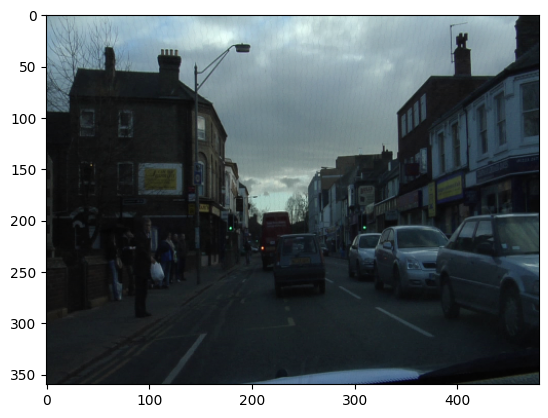

In [ ]:
u=34
plt.imshow(f(X_train[u]))

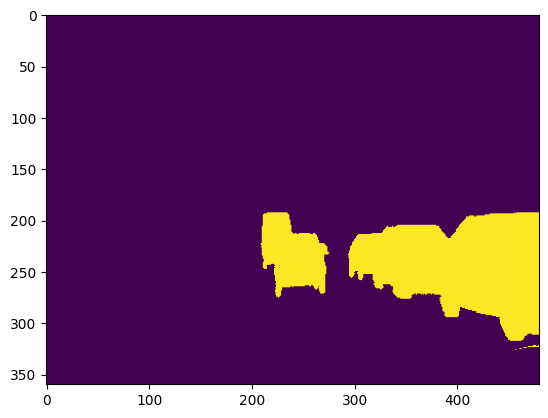

In [ ]:
plt.imshow(y_train[u])

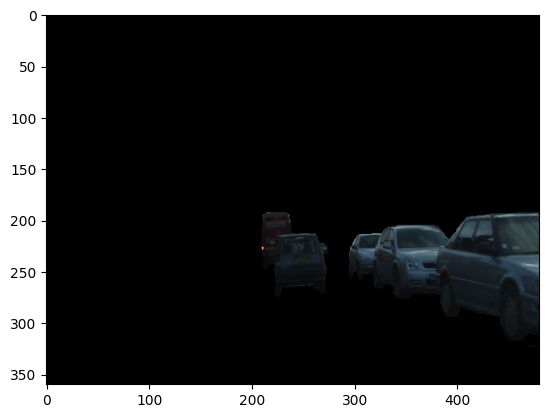

In [ ]:
plt.imshow(f(db(y_train[u])*torch.Tensor(X_train[u])))

In [ ]:
dev = ('cuda' if torch.cuda.is_available() else 'cpu')
nn1 = 64
nn2 = 128
nn3 = 256
nn4 = 256
nn5 = 128
nn6 = 64
nn7 = 64
nc = 1
ep=25
bs=12

In [ ]:
train_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader =  torch.utils.data.DataLoader(train_dset, batch_size=bs, shuffle=True)
test_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
test_loader =  torch.utils.data.DataLoader(test_dset, batch_size=bs)

In [ ]:
def inp(x, sz):
  return F.interpolate(x, size=sz, mode='bilinear')

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.c1 = nn.Sequential(nn.Conv2d(3, nn1, 3, padding=1), nn.BatchNorm2d(nn1), nn.ReLU())
    self.c2 = nn.Sequential(nn.Conv2d(nn1, nn1, 3, padding=1), nn.BatchNorm2d(nn1), nn.ReLU())
    self.c2_1 = nn.Sequential(nn.Conv2d(nn1, nn1, 3, padding=1), nn.BatchNorm2d(nn1), nn.ReLU())
    self.c3 = nn.Sequential(nn.Conv2d(nn1, nn2, 3, padding=1, stride=2), nn.BatchNorm2d(nn2), nn.ReLU())

    self.c4 = nn.Sequential(nn.Conv2d(nn2, nn2, 3, padding=1), nn.BatchNorm2d(nn2), nn.ReLU())
    self.c5 = nn.Sequential(nn.Conv2d(nn2, nn2, 3, padding=1), nn.BatchNorm2d(nn2), nn.ReLU())
    self.c5_1 = nn.Sequential(nn.Conv2d(nn2, nn2, 3, padding=1), nn.BatchNorm2d(nn2), nn.ReLU())
    self.c6 = nn.Sequential(nn.Conv2d(nn2, nn3, 3, padding=1, stride=2), nn.BatchNorm2d(nn3), nn.ReLU())

    self.c7 = nn.Sequential(nn.Conv2d(nn3, nn3, 3, padding=1), nn.BatchNorm2d(nn3), nn.ReLU())
    self.c8 = nn.Sequential(nn.Conv2d(nn3, nn3, 3, padding=1), nn.BatchNorm2d(nn3), nn.ReLU())
    self.c8_1 = nn.Sequential(nn.Conv2d(nn3, nn3, 3, padding=1), nn.BatchNorm2d(nn3), nn.ReLU())
    self.c9 = nn.Sequential(nn.Conv2d(nn3, nn4, 3, padding=1, stride=2), nn.BatchNorm2d(nn4), nn.ReLU())

    self.c10 = nn.Sequential(nn.Conv2d(nn4, nn4, 3, padding=1), nn.BatchNorm2d(nn4), nn.ReLU())
    self.c10_1 = nn.Sequential(nn.Conv2d(nn4, nn4, 3, padding=1), nn.BatchNorm2d(nn4), nn.ReLU())
    self.c11 = nn.Sequential(nn.Conv2d(nn4, nn4, 3, padding=1), nn.BatchNorm2d(nn4), nn.ReLU(),nn.Upsample(scale_factor=2, mode='bilinear'))

    self.c12 = nn.Sequential(nn.Conv2d(nn4, nn5, 3, padding=1), nn.BatchNorm2d(nn5), nn.ReLU())
    self.c12_1 = nn.Sequential(nn.Conv2d(nn5, nn5, 3, padding=1), nn.BatchNorm2d(nn5), nn.ReLU())
    self.c13 = nn.Sequential(nn.Conv2d(nn5, nn5, 3, padding=1), nn.BatchNorm2d(nn5), nn.ReLU(),nn.Upsample(scale_factor=2, mode='bilinear'))

    self.c14 = nn.Sequential(nn.Conv2d(nn5, nn6, 3, padding=1), nn.BatchNorm2d(nn6), nn.ReLU())
    self.c14_1 = nn.Sequential(nn.Conv2d(nn6, nn6, 3, padding=1), nn.BatchNorm2d(nn6), nn.ReLU())
    self.c15 = nn.Sequential(nn.Conv2d(nn6, nn6, 3, padding=1), nn.BatchNorm2d(nn6), nn.ReLU(),nn.Upsample(scale_factor=2, mode='bilinear'))

    self.c16 = nn.Sequential(nn.Conv2d(nn6, nn7, 3, padding=1), nn.BatchNorm2d(nn7), nn.ReLU())
    self.c17 = nn.Sequential(nn.Conv2d(nn7, nn7, 3, padding=1), nn.BatchNorm2d(nn7), nn.ReLU())
    self.c17_1 = nn.Sequential(nn.Conv2d(nn7, nn7, 3, padding=1), nn.BatchNorm2d(nn7), nn.ReLU())
    self.c17_2 = nn.Sequential(nn.Conv2d(nn7, nn7, 3, padding=1), nn.BatchNorm2d(nn7), nn.ReLU())
    self.c18 = nn.Sequential(nn.Conv2d(nn7, nc, 1), nn.BatchNorm2d(nc), nn.Sigmoid())
  def forward(self, x):
    z1 = self.c1(x)
    z2 = self.c2(z1)
    z2 = self.c2_1(z2)
    z3 = self.c3(z2)

    z4 = self.c4(z3)
    z5 = self.c5(z4)
    z5 = self.c5_1(z5)
    z6 = self.c6(z5)

    z7 = self.c7(z6)
    z8 = self.c8(z7)
    z8 = self.c8_1(z8)
    z9 = self.c9(z8)

    z10 = self.c10(z9)
    z10 = self.c10_1(z10)
    z11 = self.c11(z10)+z8

    z12 = self.c12(z11)
    z12 = self.c12_1(z12)
    z13 = self.c13(z12)+z5

    z14 = self.c14(z13)
    z14 = self.c14_1(z14)
    z15 = self.c15(z14)+z2

    z16 = self.c16(z15)
    z17 = self.c17(z16)
    z17 = self.c17_1(z17)
    z17 = self.c17_2(z17)
    z18 = self.c18(z17)
    return z18

In [ ]:
def loss(x, y):
  #x=x.cpu();y=y.cpu()
  o = torch.Tensor([0]).to(dev)
  l = nn.BCELoss(reduction='none')
  for i in range(x.shape[0]):
    o1 = torch.Tensor([0]).to(dev)
    p = x[i].reshape(-1,1)
    p1 = y[i].reshape(-1,1)
    o1 = l(p, p1)
    o+=o1.sum()
  return o/x.shape[0]

In [ ]:
loss(torch.Tensor([[[0,0,0], [1,1,0]]]), torch.Tensor([[[1,1,1],[1,0,1]]]))

tensor([500.], device='cuda:0')

In [ ]:
net = Net()
net.to(dev)
crit = loss
opt = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = MultiStepLR(opt, milestones=[5], gamma=0.1)
net

Net(
  (c1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (c2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (c2_1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (c3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (c4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
crit(torch.Tensor(y_test[0]), torch.Tensor(y_train[0]))

tensor([9910.2783], device='cuda:0')

In [ ]:
def vl():
  net.eval()
  with torch.no_grad():
    cur, tot = 0, 0
    for a, b in test_loader:
      a = a.to(dev)
      b = b.to(dev)
      a = a.reshape(a.shape[0], 3, 360, 480)
      out = net(a)>=0.5
      cur+=(out==b).sum().item()/(360*480)
      tot+=b.shape[0]
    print('accuracy:', cur/tot)

In [ ]:
vl()

accuracy: 11.445521177117714


Epoch 1/25 Step 4/31 LossL117782.2500
Epoch 1/25 Step 8/31 LossL114426.0312
Epoch 1/25 Step 12/31 LossL108290.5000
Epoch 1/25 Step 16/31 LossL113820.3359
Epoch 1/25 Step 20/31 LossL107510.7812
Epoch 1/25 Step 24/31 LossL115004.1094
Epoch 1/25 Step 28/31 LossL104883.7109
Epoch 2/25 Step 4/31 LossL104766.9844
Epoch 2/25 Step 8/31 LossL100147.4922
Epoch 2/25 Step 12/31 LossL100400.2188
Epoch 2/25 Step 16/31 LossL106695.5234
Epoch 2/25 Step 20/31 LossL100420.6406
Epoch 2/25 Step 24/31 LossL104159.5234
Epoch 2/25 Step 28/31 LossL108357.1406
Epoch 3/25 Step 4/31 LossL107260.8281
Epoch 3/25 Step 8/31 LossL101211.0781
Epoch 3/25 Step 12/31 LossL100582.5859
Epoch 3/25 Step 16/31 LossL105620.2656
Epoch 3/25 Step 20/31 LossL94008.7812
Epoch 3/25 Step 24/31 LossL94611.1797
Epoch 3/25 Step 28/31 LossL96972.5234
Epoch 4/25 Step 4/31 LossL94814.6719
Epoch 4/25 Step 8/31 LossL95066.0312
Epoch 4/25 Step 12/31 LossL100938.3984
Epoch 4/25 Step 16/31 LossL94569.6094
Epoch 4/25 Step 20/31 LossL100315.9219


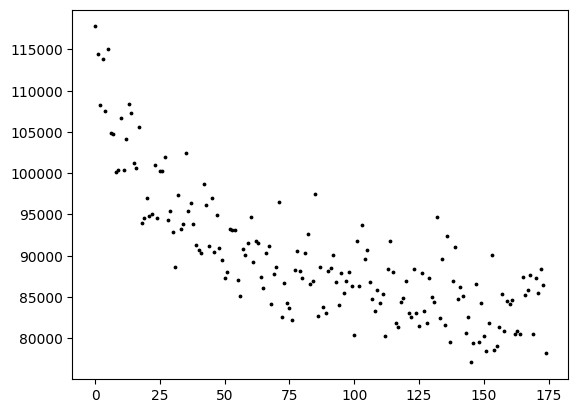

In [ ]:
q = []
tot = len(train_loader)
for i in range(ep):
    net.train()
    for j, (a, b) in enumerate(train_loader):
      a = a.to(dev)
      b = b.to(dev)
      #print(a.shape)
      a = a.reshape(a.shape[0], 3, 360, 480)
      #print(a.shape, a[0])
      out = net(a)
      out = out.reshape(out.shape[0],  360, 480)
      loss = crit(out, b)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if(j+1)%4==0:
        q.append(loss.item())
        #vl()
        net.train()
        print('Epoch {}/{} Step {}/{} LossL{:.4f}'.format(i+1, ep, j+1, tot, loss.item()))
    scheduler.step()
    #vl()
plt.scatter(range(len(q)), q, s=3, c='black')

torch.Size([1, 1, 360, 480])


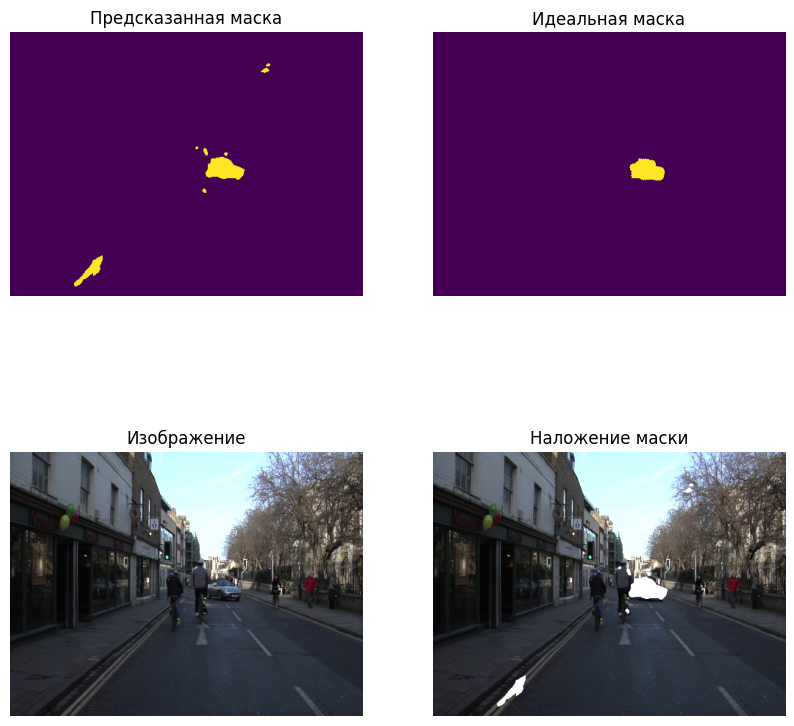

In [ ]:
from random import randint
net.eval()
with torch.no_grad():
  u = randint(0,100)
  q = net(torch.Tensor(X_test[u].reshape(1, 3, 360, 480)).to(dev))
  print(q.shape)
  fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(10,10), dpi=100)
  rr = q.cpu().detach().numpy()[0][0]>=0.75
  ax1.imshow(rr)
  ax1.set_title("Предсказанная маска")
  ax1.axis(False)
  ax2.imshow(y_test[u])
  ax2.set_title("Идеальная маска")
  ax2.axis(False)
  ax3.imshow(f(X_test[u]))
  ax3.set_title("Изображение")
  ax3.axis(False)
  ax4.imshow(f(255*db(rr)+(1-db(rr))*torch.Tensor(X_test[u])))
  ax4.set_title("Наложение маски")
  ax4.axis(False)
  fig.show()

torch.Size([1, 1, 360, 480])


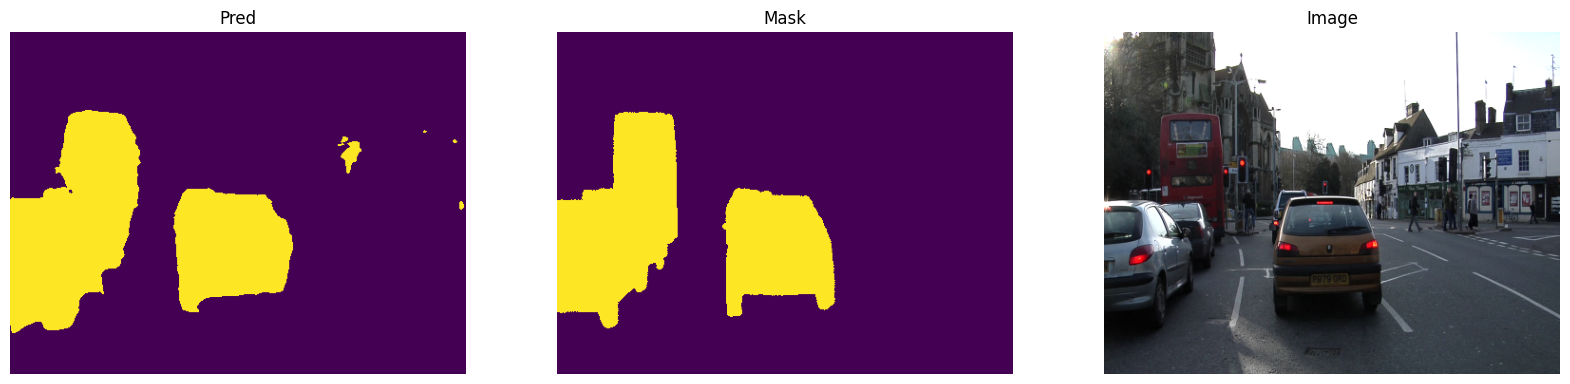

In [ ]:
net.eval()
with torch.no_grad():
  u = randint(0,300)
  q = net(torch.Tensor(X_train[u].reshape(1, 3, 360, 480)).to(dev))
  print(q.shape)
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20), dpi=100)
  ax1.imshow(q.cpu().detach().numpy()[0][0]>=0.5)
  ax1.set_title("Pred")
  ax1.axis(False)
  ax2.imshow(y_train[u])
  ax2.set_title("Mask")
  ax2.axis(False)
  ax3.imshow(f(X_train[u]))
  ax3.set_title("Image")
  ax3.axis(False)
  fig.show()

In [ ]:
#torch.save(net.state_dict(), 'segm_bil2.pth')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp segm_bil2.pth /content/drive/MyDrive